# Import Libraries

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ezzatt","key":"64045549e2dc02c5e77c499e52b4992e"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 88% 53.0M/60.3M [00:00<00:00, 71.2MB/s]
100% 60.3M/60.3M [00:00<00:00, 69.0MB/s]


In [ ]:
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from skimage.io import imread
import cv2
from PIL import Image
from skimage.transform import resize
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.models import save_model
from collections import Counter

# Preparing Data

In [ ]:
train_images = glob.glob('/content/train/*/*.jpg')
train_images[0]

'/content/train/disgust/Training_38147790.jpg'

In [ ]:
len(train_images)

28709

In [ ]:
emotion_mapping = {
    'angry': 0, 'disgust': 1, 'fear': 2,
    'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6
}

In [ ]:
train_data = pd.DataFrame({
    'path': train_images,
    'emotion': [next((v for k, v in emotion_mapping.items() if k in path), None) for path in train_images]
})

In [ ]:
train_data

,path,emotion
0,/content/train/disgust/Training_38147790.jpg,1
1,/content/train/disgust/Training_93703215.jpg,1
2,/content/train/disgust/Training_33653190.jpg,1
3,/content/train/disgust/Training_20322339.jpg,1
4,/content/train/disgust/Training_66197221.jpg,1
...,...,...
28704,/content/train/sad/Training_23338509.jpg,5
28705,/content/train/sad/Training_56548626.jpg,5
28706,/content/train/sad/Training_67021882.jpg,5
28707,/content/train/sad/Training_6956023.jpg,5


In [ ]:
test_images = glob.glob('/content/test/*/*.jpg')
test_images[0]

'/content/test/disgust/PrivateTest_93390752.jpg'

In [ ]:
len(test_images)

7178

In [ ]:
test_data = pd.DataFrame({
    'path': test_images,
    'emotion': [next((v for k, v in emotion_mapping.items() if k in path), None) for path in test_images]
})

In [ ]:
test_data

,path,emotion
0,/content/test/disgust/PrivateTest_93390752.jpg,1
1,/content/test/disgust/PublicTest_9727119.jpg,1
2,/content/test/disgust/PublicTest_43293519.jpg,1
3,/content/test/disgust/PublicTest_75935933.jpg,1
4,/content/test/disgust/PrivateTest_11895083.jpg,1
...,...,...
7173,/content/test/sad/PrivateTest_66181403.jpg,5
7174,/content/test/sad/PublicTest_38251667.jpg,5
7175,/content/test/sad/PublicTest_82355488.jpg,5
7176,/content/test/sad/PublicTest_376099.jpg,5


In [ ]:
df = pd.concat([train_data, test_data], ignore_index=False)

In [ ]:
df

,path,emotion
0,/content/train/disgust/Training_38147790.jpg,1
1,/content/train/disgust/Training_93703215.jpg,1
2,/content/train/disgust/Training_33653190.jpg,1
3,/content/train/disgust/Training_20322339.jpg,1
4,/content/train/disgust/Training_66197221.jpg,1
...,...,...
7173,/content/test/sad/PrivateTest_66181403.jpg,5
7174,/content/test/sad/PublicTest_38251667.jpg,5
7175,/content/test/sad/PublicTest_82355488.jpg,5
7176,/content/test/sad/PublicTest_376099.jpg,5


In [ ]:
df['emotion'].value_counts()

,count
emotion,
3,8989
4,6198
5,6077
2,5121
0,4953
6,4002
1,547


In [ ]:
X = []
y = []
for feature, label in df.values:
    image = cv2.imread(feature, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (48, 48), interpolation = cv2.INTER_LINEAR)
    image = image / 255.0
    X.append(image)
    y.append(label)
X = np.array(X)
y = np.array(y)

# Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
class_counts = Counter(y)
max_count = max(class_counts.values())

augmented_X = []
augmented_y = []

for label in class_counts:
    images = X[y == label]
    current_count = class_counts[label]
    needed = max_count - current_count

    if needed > 0:
        generated_images = []
        generated_labels = []

        for img in images:
            img = img.reshape((1, 48, 48, 1))
            for _ in range(needed // len(images) + 1):
                augmented = next(datagen.flow(img, batch_size=1))
                generated_images.append(augmented[0])
                generated_labels.append(label)
                if len(generated_images) >= needed:
                    break

        augmented_X.extend(generated_images)
        augmented_y.extend(generated_labels)

augmented_X = np.array(augmented_X)
augmented_y = np.array(augmented_y)

In [ ]:
X = X.reshape(-1, 48, 48, 1)
X = np.concatenate([X, augmented_X], axis=0)
y = np.concatenate([y, augmented_y], axis=0)

In [ ]:
print(X.shape)
print(y.shape)

(73192, 48, 48, 1)
(73192,)


# Split Data Into Train & Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
print(f'Length of Training Data: {len(X_train)}')
print(f'Length of Testing Data: {len(X_test)}')

Length of Training Data: 58553
Length of Testing Data: 14639


In [ ]:
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

# Model Building & Training

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, mode='max', verbose=1, factor=0.5, min_lr=0.0001)

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(7, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,5

 Total params: 5,114,503 (19.51 MB)

 Trainable params: 5,112,519 (19.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
history = model.fit (
    X_train, y_train, batch_size=64, validation_data=(X_test, y_test), epochs=30, callbacks=[early_stopping, lr_reduction],
    shuffle=True
)

Epoch 1/30
915/915 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.2833 - loss: 2.1958 - val_accuracy: 0.4607 - val_loss: 1.4228 - learning_rate: 0.0010
Epoch 2/30
915/915 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.4786 - loss: 1.3759 - val_accuracy: 0.5350 - val_loss: 1.2630 - learning_rate: 0.0010
Epoch 3/30
915/915 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.5380 - loss: 1.2233 - val_accuracy: 0.5442 - val_loss: 1.2398 - learning_rate: 0.0010
Epoch 4/30
915/915 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.5756 - loss: 1.1348 - val_accuracy: 0.5476 - val_loss: 1.2400 - learning_rate: 0.0010
Epoch 5/30
915/915 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.5958 - loss: 1.0719 - val_accuracy: 0.5414 - val_loss: 1.3534 - learning_rate: 0.0010
Epoch 6/30
915/915 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.6180 - loss: 1.0157 - val_accuracy: 0.5996 - val_loss: 1.0732 - learning_rate: 0.0010
Epoch 7/30
915/915 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.6328 - l

# Model Evaluation

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)
print("Loss:", loss)

458/458 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6864 - loss: 1.1297
Test Accuracy: 0.6839948296546936
Loss: 1.1546260118484497


In [ ]:
y_pred = model.predict(X_test)
y_test = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes))

458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
              precision    recall  f1-score   support

           0       0.61      0.53      0.57      2000
           1       0.87      0.93      0.90      1800
           2       0.53      0.43      0.48      1987
           3       0.86      0.83      0.84      1800
           4       0.62      0.69      0.65      2479
           5       0.55      0.58      0.57      2402
           6       0.78      0.83      0.80      2171

    accuracy                           0.68     14639
   macro avg       0.69      0.69      0.69     14639
weighted avg       0.68      0.68      0.68     14639



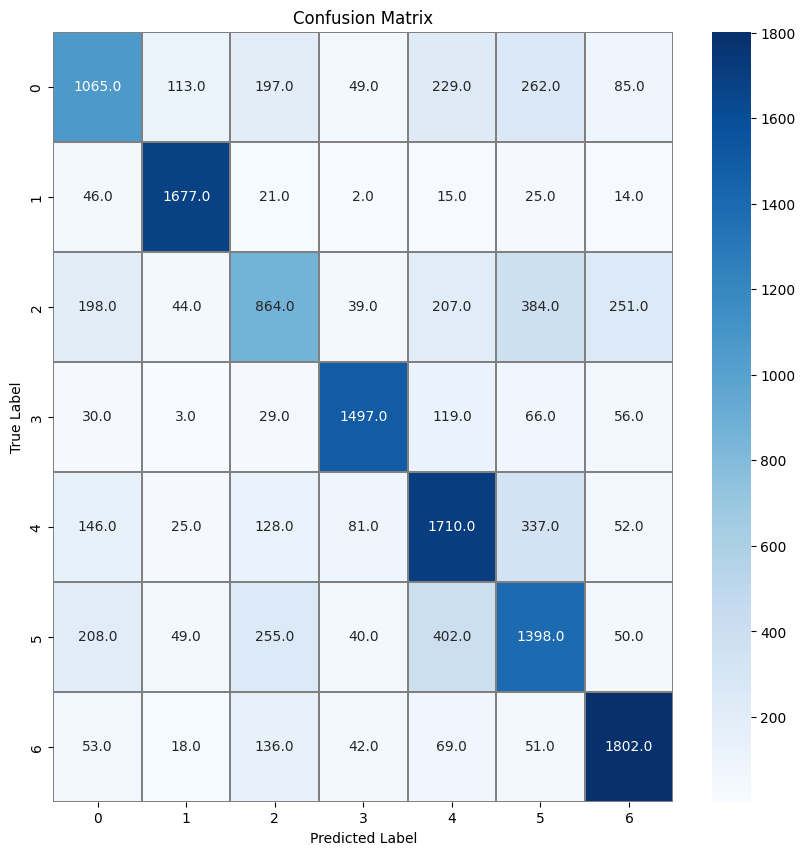

In [ ]:
confusion_mtx = confusion_matrix(y_test, y_pred_classes)
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

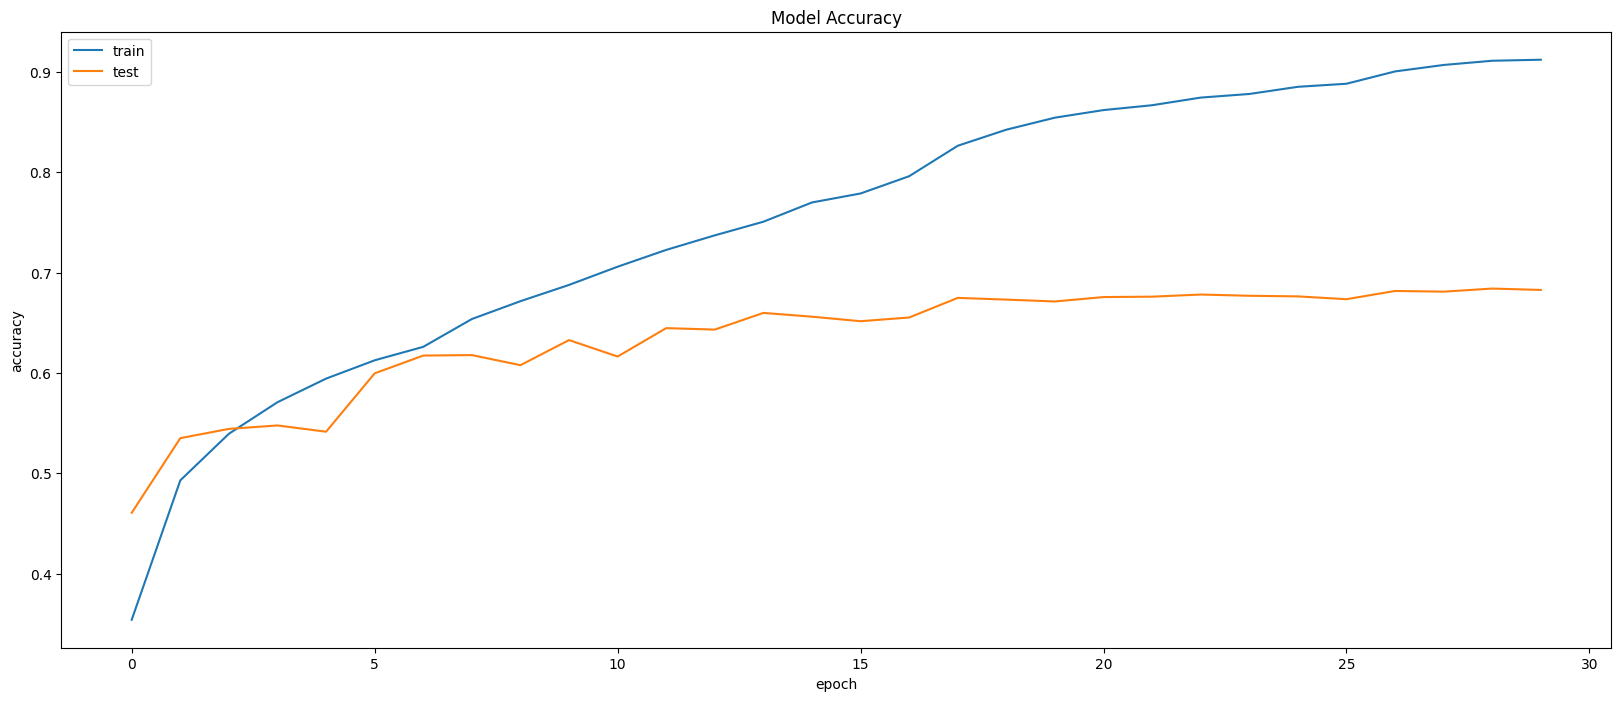

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

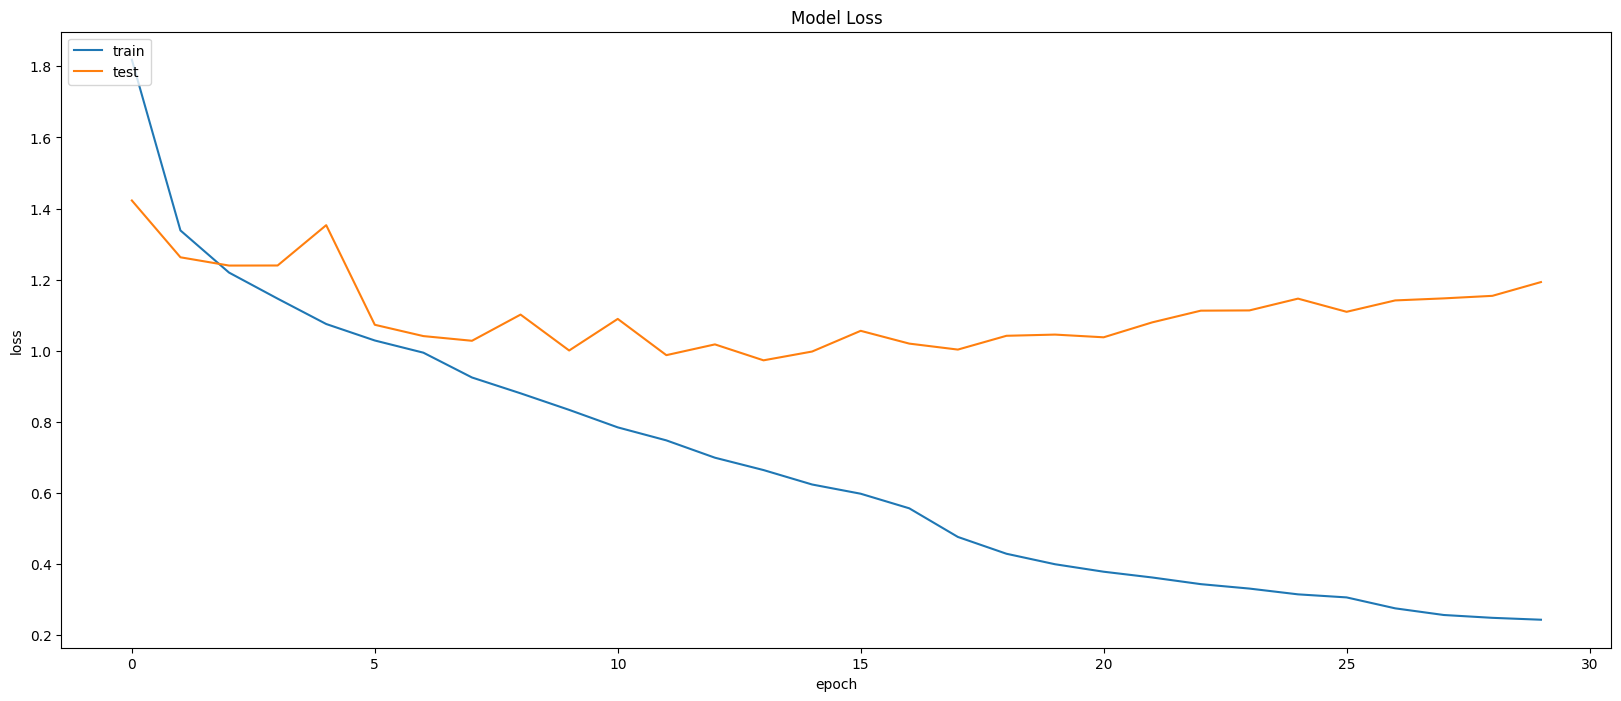

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()